### Load data

In [4]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import chain

In [2]:
train = pd.read_csv('../data/train.csv', index_col='ex_id')
dev = pd.read_csv('../data/dev.csv', index_col='ex_id')
test = pd.read_csv('../data/test_no_label.csv', index_col='ex_id')

In [5]:
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("../data/tokens/train_data_tokens.pkl", "rb"))
all_train_tokens_set = pkl.load(open("../data/tokens/all_train_tokens.pkl", "rb"))
all_train_tokens = list(chain.from_iterable(train_data_tokens))

val_data_tokens = pkl.load(open("../data/tokens/val_data_tokens.pkl", "rb"))
test_data_tokens = pkl.load(open("../data/tokens/test_data_tokens.pkl", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))
print ("Total number of *unique* tokens in train dataset is {}".format(len(set(all_train_tokens))))

Train dataset size is 250874
Val dataset size is 35918
Test dataset size is 72165
Total number of tokens in train dataset is 12969997
Total number of *unique* tokens in train dataset is 114051


### Vocabulary

In [7]:
from collections import Counter

max_vocab_size = 9029
# save index 0 for unk and 1 for pad, standard
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [11]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 250874
Val dataset size is 35918
Test dataset size is 72165


### PyTorch DataLoader 

In [25]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import pickle as pkl
from collections import Counter
import random
import matplotlib.pyplot as plt
import spacy

In [55]:
train_targets = train.label.values
val_targets = dev.label.values

train_targets = (train_targets - 0.5) * 2
val_targets = (val_targets - 0.5) * 2

In [26]:
train_data_lens = [len(data) for data in train_data_indices]
val_data_lens = [len(data) for data in val_data_indices]
test_data_lens = [len(data) for data in test_data_indices]

[]

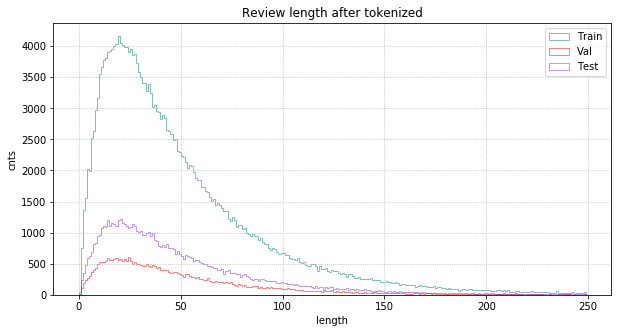

In [27]:
plt.figure(figsize =[10, 5])

plt.hist(train_data_lens, bins=np.arange(0, 250, 1), alpha = 0.5, label = 'Train', histtype = 'step', color = 'teal')
#plt.vlines(np.median(train_data_lens), ymin = 0, ymax = 710, color = 'teal', linestyle = ':', alpha = 0.5)

plt.hist(val_data_lens, bins=np.arange(0, 250, 1), alpha = 0.5, label = 'Val', histtype = 'step', color = 'red')
#plt.vlines(np.median(val_data_lens), ymin = 0, ymax = 475, color = 'red', linestyle = ':', alpha = 0.5)

plt.hist(test_data_lens, bins=np.arange(0, 250, 1), alpha = 0.5, label = 'Test', histtype = 'step', color = 'blueviolet')
#plt.vlines(np.median(test_data_lens), ymin = 0, ymax = 880, color = 'blueviolet', linestyle = ':', alpha = 0.5)

plt.title('Review length after tokenized')
plt.ylabel('cnts')
plt.xlabel('length')
plt.legend()
plt.grid(linestyle = ':')
plt.plot()

In [28]:
MAX_SENTENCE_LENGTH = 100

In [33]:
import torch
from torch.utils.data import Dataset

class FakeReviewDataset(Dataset):
    """
    Class that represents a train/validation dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of fake_review tokens 
        @param target_list: list of fake_review targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

In [34]:
train_dataset = FakeReviewDataset(train_data_indices, train_targets)
val_dataset = FakeReviewDataset(val_data_indices, val_targets)

In [35]:
def fakereview_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [36]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=fakereview_collate_func,
                                           shuffle=True)

In [37]:
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=fakereview_collate_func,
                                           shuffle=True)

### Bag-of-Words model in PyTorch

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [60]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 1)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out


In [61]:
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [62]:
# Criterion and Optimizer
criterion = torch.nn.SoftMarginLoss()  

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [63]:
num_epochs = 10 # number epoch to train

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        
        data_batch, length_batch, label_batch = data.type(torch.LongTensor), lengths, labels
        
        print('model')
        print(model(data_batch, length_batch))
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        
        print('after softmax')
        print(outputs)
        
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        
        data_batch, length_batch, label_batch = data.type(torch.LongTensor), lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc = test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))

RuntimeError: output with shape [32, 1] doesn't match the broadcast shape [32, 32]